<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/08_RecommendationSystem/Assignment/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install surprise


#### 1) Importing Liberaries & reading all data





In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)

import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
#%matplotlib inline
sns.set(style="whitegrid")

from sklearn.preprocessing import MinMaxScaler


from surprise import Dataset
from surprise import SVD
from surprise.model_selection.search import GridSearchCV 
from surprise.reader import Reader
from surprise.model_selection import train_test_split
from surprise.model_selection.split import KFold 
import surprise.accuracy as accuracy
from surprise.model_selection.validation import cross_validate
import random
from surprise import KNNWithMeans


from collections import defaultdict




In [3]:
basepath =  "/RecommendationSys/"
#basepath = "/content/drive/MyDrive/Colab Notebooks/Greatelearning/RecommendationSys/"

data_rev1 = pd.read_csv(basepath+"phone_user_review_file_1.csv",encoding='latin-1')
data_rev2 = pd.read_csv(basepath+"phone_user_review_file_2.csv",encoding='latin-1')
data_rev3 = pd.read_csv(basepath+"phone_user_review_file_3.csv",encoding='latin-1')
data_rev4 = pd.read_csv(basepath+"phone_user_review_file_4.csv",encoding='latin-1')
data_rev5 = pd.read_csv(basepath+"phone_user_review_file_5.csv",encoding='latin-1')
data_rev6 = pd.read_csv(basepath+"phone_user_review_file_6.csv",encoding='latin-1')




In [4]:
# Check the Details for the data
data_list = [data_rev1,data_rev2,data_rev3,data_rev4,data_rev5,data_rev6]
for data_object in data_list:
  print(data_object.columns)
  print(data_object.head())

Index(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score',
       'score_max', 'extract', 'author', 'product'],
      dtype='object')
                        phone_url       date lang country            source  \
0  /cellphones/samsung-galaxy-s8/   5/2/2017   en      us  Verizon Wireless   
1  /cellphones/samsung-galaxy-s8/  4/28/2017   en      us       Phone Arena   
2  /cellphones/samsung-galaxy-s8/   5/4/2017   en      us            Amazon   
3  /cellphones/samsung-galaxy-s8/   5/2/2017   en      us           Samsung   
4  /cellphones/samsung-galaxy-s8/  5/11/2017   en      us  Verizon Wireless   

                domain  score  score_max  \
0  verizonwireless.com   10.0       10.0   
1       phonearena.com   10.0       10.0   
2           amazon.com    6.0       10.0   
3          samsung.com    9.2       10.0   
4  verizonwireless.com    4.0       10.0   

                                             extract       author  \
0  As a diehard Samsung fan who has had 

##### Merge the provided CSVs into one data-frame.


In [5]:
data = pd.concat(data_list)
data.reset_index(inplace=True)
data.drop(columns=["index"],inplace=True)
data.tail(n=10000)


,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
1405133,/cellphones/sony-cmd-z5/,12/3/2001,en,gb,Dooyoo,dooyoo.co.uk,6.0,10.0,This a realtivly new phone and has an importan...,anonym,Sony CMD-Z5
1405134,/cellphones/sony-cmd-z5/,10/22/2001,en,gb,Dooyoo,dooyoo.co.uk,10.0,10.0,"THE best phone on the market, classy and featu...",timbos,Sony CMD-Z5
1405135,/cellphones/sony-cmd-z5/,9/25/2001,en,gb,Dooyoo,dooyoo.co.uk,10.0,10.0,When looking at the Sony CMD-Z5 it can be very...,M_J_Carrier,Sony CMD-Z5
1405136,/cellphones/sony-cmd-z5/,8/12/2001,en,gb,Dooyoo,dooyoo.co.uk,6.0,10.0,I`ve had the Sony CMD-Z5 for just about a year...,Verbal,Sony CMD-Z5
1405137,/cellphones/sony-cmd-z5/,7/25/2001,en,gb,Dooyoo,dooyoo.co.uk,8.0,10.0,Now that my current phone's contract is immine...,curly00,Sony CMD-Z5
...,...,...,...,...,...,...,...,...,...,...,...
1415128,/cellphones/alcatel-ot-club_1187/,5/12/2000,de,de,Ciao,ciao.de,2.0,10.0,Weil mein Onkel bei ALcatel arbeitet habe ich ...,david.paul,Alcatel Club Plus Handy
1415129,/cellphones/alcatel-ot-club_1187/,5/11/2000,de,de,Ciao,ciao.de,10.0,10.0,Hy Liebe Leserinnen und Leser!! Ich habe seit ...,Christiane14,Alcatel Club Plus Handy
1415130,/cellphones/alcatel-ot-club_1187/,5/4/2000,de,de,Ciao,ciao.de,2.0,10.0,"Jetzt hat wohl Alcatell gedacht ,sie machen wa...",michaelawr,Alcatel Club Plus Handy
1415131,/cellphones/alcatel-ot-club_1187/,5/1/2000,de,de,Ciao,ciao.de,8.0,10.0,Ich bin seit 2 Jahren (stolzer) Besitzer eines...,claudia0815,Alcatel Club Plus Handy


#### Exploratory Data Analysis

In [6]:
# Create a copy of the data for analysis
data_analysis = data.copy()

##### Check a few observations and shape of the data-frame.


In [7]:
print("Shape of the data - ",data_analysis.shape)
print("Columns of data - ",data_analysis.columns)

Shape of the data -  (1415133, 11)
Columns of data -  Index(['phone_url', 'date', 'lang', 'country', 'source', 'domain', 'score',
       'score_max', 'extract', 'author', 'product'],
      dtype='object')


In [8]:
# Random check on data for 5o records
data_analysis.sample(n=25,random_state=612)

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
1381066,/cellphones/samsung-mm-a700-sph-a700/,9/18/2004,en,us,Phone Scoop,phonescoop.com,3.0,10.0,Sprint missed the boat on the fundamentals wit...,GrandWazoo,MM-A700 / SPH-A700
159224,/cellphones/lg-g5/,1/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,"Just got this a couple of weeks ago, really ni...",Hunts1,LG G5
166941,/cellphones/microsoft-lumia-640-dual-sim/,3/10/2016,ru,ru,Yandex,market.yandex.ru,6.0,10.0,Ð¡ÑÐµÐ´Ð½Ð¸Ð¹ ÑÐ¼Ð°ÑÑÑÐ¾Ð½. ÐÐ· Ð¿Ð»ÑÑ...,NaN,Microsoft Lumia 640 3G Dual Sim
340422,/cellphones/samsung-galaxy-s5/,5/24/2016,en,in,Flipkart,flipkart.com,8.0,10.0,Good...reasonable. .original product of Samsun...,Sandeep Kumar...,"SAMSUNG Galaxy S5 (Copper Gold, 16 GB)"
290110,/cellphones/samsung-galaxy-note-4/,11/13/2014,en,ca,Amazon,amazon.ca,10.0,10.0,Shipped very fast and came with everything you...,mike hawdon,"Tech Armor Galaxy Note 4 Screen Protector, Tec..."
1166492,/cellphones/nokia-e71/,2/20/2009,en,us,Amazon,amazon.com,4.0,10.0,"Phone arrived, and the initial looks of it wer...",The mother of all prduct reviews,Nokia E71x Unlocked Phone with QWERTY Keyboard...
264600,/cellphones/apple-iphone-6/,11/13/2014,en,us,Amazon,amazon.com,8.0,10.0,The phone was to my expectations and I was hap...,Amazon Customer,Apple iPhone 6 16GB Factory Unlocked GSM 4G LT...
1275859,/cellphones/nokia-6680/,1/21/2007,en,gb,Amazon,amazon.co.uk,8.0,10.0,Its hot chrome packing slick phone albeit it b...,Amazon Customer,Nokia 6680 Smartphone
416067,/cellphones/sony-xperia-z3-compact/,11/25/2014,en,gb,Amazon,amazon.co.uk,6.0,10.0,I'd like to say this phone is great- and so mu...,Jsphstry,Sony Xperia Z3 Compact UK SIM-Free Smartphone ...
306382,/cellphones/acer-liquid-z630/,12/21/2015,fr,fr,Amazon,amazon.fr,2.0,10.0,laissant un samsung s5 j'ai pris celui la car ...,Client d'Amazon,Acer Liquid Z630 Smartphone dÃ©bloquÃ© 4G (Ecr...


##### formating the phone url Columns

In [9]:
# formating the phone url Columns

# Check is all the rows starts with "cellphones"
print(data_analysis['phone_url'].str.startswith('/cellphones/').value_counts() )
data_analysis['phone_url'] = data_analysis['phone_url'].str.replace('/cellphones/','')
data_analysis['phone_url'] = data_analysis['phone_url'].str[:-1]
data_analysis['phone_url'].value_counts()

True    1415133
Name: phone_url, dtype: int64


samsung-galaxy-s-iii      17093
apple-iphone-5s           16379
samsung-galaxy-s6         16145
samsung-galaxy-s5         16082
samsung-galaxy-s7-edge    15917
                          ...  
zte-grand-x-lte               1
orange-spv-c600               1
samsung-p500                  1
sagem-my-c2-2                 1
i-mate-ultimate-9150          1
Name: phone_url, Length: 5556, dtype: int64

##### Analysis the Column "author" 

In [10]:
#pd.set_option('display.max_rows', None)
print("Not of observation with empty - ",data_analysis["author"].isna().sum())
print("Not of observation with empty % - ",(data_analysis["author"].isna().sum() / data_analysis.shape[0])*100) 

Not of observation with empty -  63202
Not of observation with empty % -  4.466152651376231


Since only 1000000 are request for analysis, removing the observation where author names are empty





 

In [11]:

data_analysis.dropna(subset=["author"],inplace=True)
data_analysis.isna().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        60893
score_max    60893
extract      15515
author           0
product          0
dtype: int64

##### Analysis the Column "Score and score_max"

In [12]:
##### Analysis the Column "Score and score_max"

In [13]:
print("Not of observation with empty - ",data_analysis["score"].isna().sum())
print("Not of observation with empty % - ",(data_analysis["score"].isna().sum() / data_analysis.shape[0])*100) 

Not of observation with empty -  60893
Not of observation with empty % -  4.504149989903331


Since only 1000000 are request for analysis, removing the observation where score names are empty

In [14]:
data_analysis.dropna(subset=["score"],inplace=True)
data_analysis.isna().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score            0
score_max        0
extract      15121
author           0
product          0
dtype: int64

In [15]:
# is there any observation with score greater than max score ?
data_analysis.query("score > score_max").count().sum()


0

 - is there any observation with score greater than max score ? -NO

###### Round off scores to the nearest integers



In [16]:
data_analysis["score"] = np.round(data_analysis["score"])
data_analysis["score"].unique()

array([10.,  6.,  9.,  4.,  8.,  2.,  7.,  5.,  3.,  1.,  0.])

In [17]:
# is the scoring is done on same scale  ( 1 -10) ?  
data_analysis["score_max"].value_counts()

10.0    1291038
Name: score_max, dtype: int64

- is the scoring is done on same scale  ( 1 -10) ?  - YES

##### Dropping irrelevant features & removing duplicate columns

In [18]:
# Removing the duplicate rows - when phone_url,author & score are same
rows_with_duplicate = int(data_analysis.shape[0])

print("# of Observations - ",rows_with_duplicate)
data_analysis.drop_duplicates(subset=['phone_url','author','score'],keep='first',inplace=True)

rows_without_duplicate = int(data_analysis.shape[0])
print("# of Observations after removing duplicate - ",rows_without_duplicate)

print("% of rows duplicated rows removed - " , ((rows_with_duplicate - rows_without_duplicate)/rows_with_duplicate)*100)

# of Observations -  1291038
# of Observations after removing duplicate -  1113596
% of rows duplicated rows removed -  13.744134564590663


- 13% duplicated rows have been removed , it's OK since only 10L rows are to be considered for the analysis. 

In [19]:
# 'phone_url','author','score' are considered for the analysis on other rows are removed.
data_analysis = data_analysis[['phone_url','author','score']]
data_analysis.head()

,phone_url,author,score
0,samsung-galaxy-s8,CarolAnn35,10.0
1,samsung-galaxy-s8,james0923,10.0
2,samsung-galaxy-s8,R. Craig,6.0
3,samsung-galaxy-s8,Buster2020,9.0
4,samsung-galaxy-s8,S Ate Mine,4.0


##### Sampling 1000000 rows

In [20]:
data_analysis = data_analysis.sample(n=1000000,random_state=612)
print("Check the shape ", data_analysis.shape)
print(" missing values ", data_analysis.isna().sum().sum())

Check the shape  (1000000, 3)
 missing values  0


### 2) Answer the following questions 

1.   Identify the most rated features
2.   Identify the users with most number of reviews.
3.   Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final
dataset

##### most rated features

In [21]:
data_groupby_phone = data_analysis.groupby(by="phone_url").count()
data_groupby_phone = data_groupby_phone.sort_values(by=['author'],ascending=False)
data_groupby_phone["author"].head(10)

phone_url
samsung-galaxy-s5                                    11726
samsung-galaxy-s6                                    11426
motorola-moto-g                                      10782
samsung-galaxy-s7-edge                               10695
apple-iphone-5s                                      10524
samsung-i9500-galaxy-s-iv                             9829
samsung-galaxy-s7-789999                              9504
huawei-p8-lite                                        6766
apple-iphone-4s                                       6511
samsung-galaxy-s4-mini-gt-i9190-gt-i9192-dual-sim     6345
Name: author, dtype: int64

 ##### users with most number of reviews

In [22]:
data_groupby_author = data_analysis.groupby(by="author").count()
data_groupby_author = data_groupby_author.sort_values(by='phone_url',ascending=False)
data_groupby_author['phone_url'].head(10)

author
Amazon Customer    5012
Cliente Amazon     1723
Anonymous          1401
Amazon Kunde       1221
Client d'Amazon    1029
David               572
Alex                531
Daniel              501
Chris               499
Marco               449
Name: phone_url, dtype: int64

#### Filter Data - product with 50 rating and User gave 50 rating

In [23]:
data_groupby_phone = data_groupby_phone.query("author > 50")
data_groupby_author = data_groupby_author.query("phone_url > 50")
data_analysis = data_analysis[ data_analysis["phone_url"].isin(data_groupby_phone.index) | data_analysis["author"].isin(data_groupby_author.index)]
print("Data Size selected for Model Building-- ",data_analysis.shape)
print("Columns Selected -- ",data_analysis.columns)
data_analysis.head()

Data Size selected for Model Building--  (953196, 3)
Columns Selected --  Index(['phone_url', 'author', 'score'], dtype='object')


,phone_url,author,score
1279750,nokia-n73,dd-xd,10.0
178322,huawei-p8-lite,Bouwman,9.0
342503,samsung-galaxy-s5,across2k13,10.0
1151689,htc-touch-diamond-2,Melissa MÃ¼hleisen,2.0
1122190,htc-evo-design-4g,stacee8675309,3.0


#### User & Product

In [24]:
print("Unique products - ", data_analysis['phone_url'].nunique())
print("No of USers  - ", data_analysis['author'].nunique())

Unique products -  3767
No of USers  -  678013


### **popularity based model**

In [25]:
rating_mean_count =  pd.DataFrame(data_analysis.groupby(by="phone_url")["score"].mean())
rating_mean_count["rating_count"] =  pd.DataFrame(data_analysis.groupby(by="phone_url")["score"].count())

##### Caculating Weighted Score 

W = ((R*V) + (C*M)) / ( V+M )
 - R = Average score for a product
 - V = total number of counts recived for product
 - M = min votes required to be listed ( 90 % quantile )
 - C = Average vote across the whole product

In [26]:
R = rating_mean_count["score"]
V = rating_mean_count["rating_count"]
M = rating_mean_count["rating_count"].quantile(0.9)
C = rating_mean_count["score"].mean() #Product to be considered only when it has more rating count than 90% of the product
rating_mean_count["weigted_score"]  = ( (R*V)+ (C*M) / ( V+M ))

In [27]:
# minmaxscale = MinMaxScaler()
# rating_mean_count["score_nor"] = minmaxscale.fit_transform(rating_mean_count[["score"]])
# rating_mean_count["rating_count_nor"] = minmaxscale.fit_transform(rating_mean_count[["rating_count"]])
# rating_mean_count["weigted_score_nor"] = minmaxscale.fit_transform(rating_mean_count[["weigted_score"]])

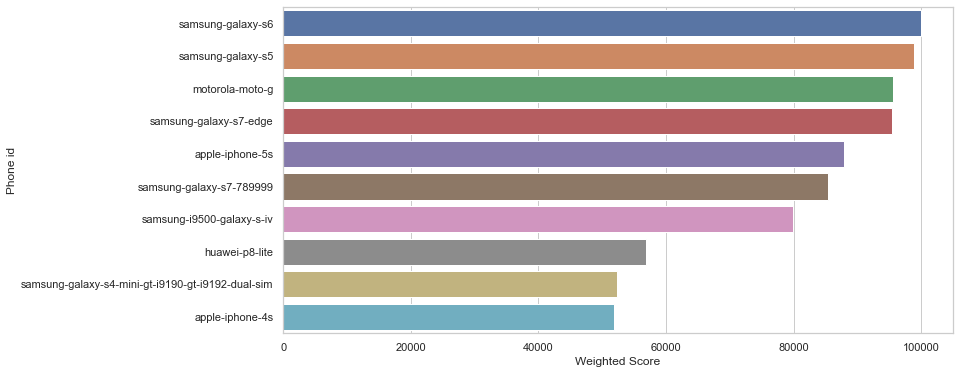

In [28]:
plt.figure(figsize=(12,6))
vis_data = rating_mean_count.sort_values(by=["weigted_score","rating_count","score"],ascending=False)
vis_data.reset_index(inplace=True)
sns.barplot(data=vis_data.head(10) ,y="phone_url",x="weigted_score",orient="h")
plt.xlabel("Weighted Score")
plt.ylabel("Phone id")
plt.show()

In [29]:
def popularity_recommendation(fileter_col_list,top_n):
  top_n_item = []
  return rating_mean_count.sort_values(by=fileter_col_list,ascending=False).index[:top_n]

##### Top 5 recommendation

In [30]:
popularity_recommendation(["weigted_score","rating_count","score"],5)

Index(['samsung-galaxy-s6', 'samsung-galaxy-s5', 'motorola-moto-g',
       'samsung-galaxy-s7-edge', 'apple-iphone-5s'],
      dtype='object', name='phone_url')

### **collaborative filtering**

In [31]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, details in predictions:
        if details['was_impossible'] == False:
            top_n[uid].append((iid, est))
        
        

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


##### Impute outliers

In [32]:
print(data_analysis["score"].value_counts())
data_analysis["score"].value_counts(normalize=True)*100

10.0    474636
8.0     217034
2.0      87466
6.0      84177
4.0      52039
9.0      25575
7.0       5663
5.0       3004
1.0       1954
3.0       1623
0.0         25
Name: score, dtype: int64


10.0    49.794166
8.0     22.769084
2.0      9.176077
6.0      8.831027
4.0      5.459423
9.0      2.683079
7.0      0.594107
5.0      0.315150
1.0      0.204995
3.0      0.170269
0.0      0.002623
Name: score, dtype: float64

 - Rating count for (0,1,3) are less than 1% which can be assigned with 2 rating.
 - Rating count of ( 5,6) are less than 1% which can be assigned to 6

In [33]:
data_analysis["score_imp"]  = np.where(data_analysis["score"].isin([0,1,3]),2, data_analysis["score"])
data_analysis["score_imp"] = np.where(data_analysis["score_imp"].isin([5,7]),6,data_analysis["score_imp"])
data_analysis["score_imp"].value_counts(normalize=True)*100

10.0    49.794166
8.0     22.769084
6.0      9.740284
2.0      9.553964
4.0      5.459423
9.0      2.683079
Name: score_imp, dtype: float64

##### User-user collabrative filtering

In [34]:
# reducing the data size to 10K considering limitation computation resources
data_analysis_CF =  data_analysis.sample(random_state=612,n=5000)
data_analysis_CF.head()

,phone_url,author,score,score_imp
452424,sony-xperia-z2,StU,6.0,6.0
965710,nokia-asha-300,yskander flores,10.0,10.0
213790,wiko-fever,JPK,10.0,10.0
613556,samsung-galaxy-mega-6-3-i9200,A Manning,6.0,6.0
623654,lg-freedom-ii,Sandy,4.0,4.0


###### Train Model with Cross Validation - Without treating outlier (Score)

In [35]:

reader = Reader(rating_scale=(0, 5))
user_base_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
param_grid = {'k': [2,5],
              'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True]}              }
kmean_gs_user_base = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=KFold(n_splits=3,random_state=123),return_train_measures = True) 
kmean_gs_user_base.fit(user_base_data)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

Model performance

In [36]:
print("Best Score" , kmean_gs_user_base.best_score['rmse'])
print("best hyperparameter", kmean_gs_user_base.best_params['rmse'])
results_df = pd.DataFrame.from_dict(kmean_gs_user_base.cv_results)
results_df[["mean_train_rmse","std_train_rmse","mean_test_rmse","std_test_time"]].sort_values(by=["mean_test_rmse","mean_train_rmse"])


Best Score 3.957256205367107
best hyperparameter {'k': 2, 'bsl_options': {'method': 'als', 'reg': 1}, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}


,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_time
0,3.825466,0.002344,3.957256,4.701457e-04
2,3.825466,0.002344,3.957256,3.856726e-03
4,3.825466,0.002344,3.957256,8.076918e-04
6,3.825466,0.002344,3.957256,3.395730e-03
8,3.825466,0.002344,3.957256,2.870867e-02
10,3.825466,0.002344,3.957256,1.690090e-03
12,3.825466,0.002344,3.957256,3.692579e-03
14,3.825466,0.002344,3.957256,4.052337e-07
9,3.831493,0.001943,3.957256,3.093702e-03
11,3.831493,0.001943,3.957256,1.238874e-03


###### Train Model with Cross Validation - With treating outlier (Score)

In [37]:
reader = Reader(rating_scale=(0, 5))
user_base_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score_imp']],reader)
param_grid = {'k': [2,5],
              'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True]}              }
kmean_gs_user_base_v1 = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=KFold(n_splits=3,random_state=123),return_train_measures = True) 
kmean_gs_user_base_v1.fit(user_base_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

In [38]:
print("Best Score" , kmean_gs_user_base_v1.best_score['rmse'])
print("best hyperparameter", kmean_gs_user_base_v1.best_params['rmse'])
results_df = pd.DataFrame.from_dict(kmean_gs_user_base_v1.cv_results)
results_df[["mean_train_rmse","std_train_rmse","mean_test_rmse","std_test_time"]].sort_values(by=["mean_test_rmse","mean_train_rmse"])

Best Score 3.955107114327431
best hyperparameter {'k': 2, 'bsl_options': {'method': 'als', 'reg': 1}, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}}


,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_time
0,3.823845,0.002269,3.955107,0.000826
2,3.823845,0.002269,3.955107,0.004370
4,3.823845,0.002269,3.955107,0.001261
6,3.823845,0.002269,3.955107,0.001240
8,3.823845,0.002269,3.955107,0.003765
10,3.823845,0.002269,3.955107,0.002829
12,3.823845,0.002269,3.955107,0.005183
14,3.823845,0.002269,3.955107,0.000472
9,3.829700,0.001925,3.955107,0.001413
11,3.829700,0.001925,3.955107,0.005079


Observation :
No Major difference on the model performance when capping the score value

###### predicting with best Model & Top 5 recommendation

In [39]:
reader = Reader(rating_scale=(0, 5))
user_base_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
trainset = user_base_data.build_full_trainset()
testset = trainset.build_anti_testset()
best_userbase = kmean_gs_user_base.best_estimator['rmse']
best_userbase.fit(trainset)
userbase_prediction = best_userbase.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [40]:
userbase_model_pred = pd.DataFrame([[i.uid, i.iid, i.est,i.details['was_impossible']] for i in userbase_prediction], columns=['user_id', 'movie_id', 'score',"was_impossible"])
userbase_model_pred.head()

,user_id,movie_id,score,was_impossible
0,StU,nokia-asha-300,5.0,False
1,StU,wiko-fever,5.0,False
2,StU,samsung-galaxy-mega-6-3-i9200,5.0,False
3,StU,lg-freedom-ii,5.0,False
4,StU,samsung-galaxy-s7-edge,5.0,False


In [41]:
test_users = userbase_model_pred.sample(n=10,random_state=123)
def user_base_recommendation(user_list,n=5):
  recommendation = dict();
  for user_id in user_list:
    movie_list = userbase_model_pred[userbase_model_pred.user_id == user_id].sort_values(by=["score"],ascending=False).head(n=n)["movie_id"]
    recommendation[user_id] = list(movie_list)
    print(user_id, list(movie_list))
  return recommendation

recommendation = user_base_recommendation(test_users["user_id"])

Amanda ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
RaMonti ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Elisa ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Martha G. ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Mary Duncan ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Dante ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
petrolal ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
tantramen ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Mohd Salim ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Tottetomat ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w8

 - In Populatity recommendation the movie list is constant for all the users , where  in the CF model the movie are list based on user preference

#### Item Based Collaboration model

In [42]:
reader = Reader(rating_scale=(0, 5))
item_base_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
param_grid = {'k': [2,5],
              'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [False]}              }
kmean_gs_item_base = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=KFold(n_splits=3,random_state=123),return_train_measures = True) 
kmean_gs_item_base.fit(item_base_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity ma

In [43]:
print("Best Score" , kmean_gs_item_base.best_score['rmse'])
print("best hyperparameter", kmean_gs_item_base.best_params['rmse'])
results_df = pd.DataFrame.from_dict(kmean_gs_item_base.cv_results)
results_df[["mean_train_rmse","std_train_rmse","mean_test_rmse","std_test_time"]].sort_values(by=["mean_test_rmse","mean_train_rmse"])

Best Score 3.947249929275688
best hyperparameter {'k': 2, 'bsl_options': {'method': 'als', 'reg': 1}, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_time
0,3.825466,0.002344,3.94725,0.001638
2,3.825466,0.002344,3.94725,0.005432
4,3.825466,0.002344,3.94725,0.003289
8,3.825466,0.002344,3.94725,0.004986
10,3.825466,0.002344,3.94725,0.000823
6,3.825466,0.002344,3.94725,0.001413
12,3.825466,0.002344,3.94725,0.001247
14,3.825466,0.002344,3.94725,0.001697
9,3.831018,0.001590,3.94725,0.002156
11,3.831018,0.001590,3.94725,0.000942


###### predicting with best Model & Top 5 recommendation

In [44]:
reader = Reader(rating_scale=(0, 5))
item_base_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
trainset = item_base_data.build_full_trainset()
testset = trainset.build_anti_testset()
best_itembase = kmean_gs_item_base.best_estimator['rmse']
best_itembase.fit(trainset)
itembase_prediction = best_itembase.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [45]:
itembase_model_pred = pd.DataFrame([[i.uid, i.iid, i.est,i.details['was_impossible']] for i in itembase_prediction], columns=['user_id', 'movie_id', 'score',"was_impossible"])
itembase_model_pred.head()

,user_id,movie_id,score,was_impossible
0,StU,nokia-asha-300,5.0,False
1,StU,wiko-fever,5.0,False
2,StU,samsung-galaxy-mega-6-3-i9200,5.0,False
3,StU,lg-freedom-ii,4.0,False
4,StU,samsung-galaxy-s7-edge,5.0,False


In [46]:
itembase_model_pred = pd.DataFrame([[i.uid, i.iid, i.est,i.details['was_impossible']] for i in itembase_prediction], columns=['user_id', 'movie_id', 'score',"was_impossible"])
test_users = itembase_model_pred.sample(n=10,random_state=123)

def item_base_recommendation(user_list,n=5):
  recommendation = dict();
  for user_id in user_list:
    movie_list = itembase_model_pred[itembase_model_pred.user_id == user_id].sort_values(by=["score"],ascending=False).head(n=n)["movie_id"]
    recommendation[user_id] = list(movie_list)
    print(user_id, list(movie_list))
  return recommendation

recommendation = item_base_recommendation(test_users["user_id"])

Amanda ['sony-xperia-z2', 'nokia-5110', 'samsung-messager-touch-r630-r631', 'sony-xperia-z3plus', 'lg-shine-ke970']
RaMonti ['sony-xperia-z2', 'cubot-s308', 'sony-xperia-z3plus', 'lg-shine-ke970', 'motorola-razr-v3m-357929']
Elisa ['sony-xperia-z2', 'lenovo-ideaphone-a859', 'cubot-s308', 'samsung-messager-touch-r630-r631', 'sony-xperia-z3plus']
Martha G. ['sony-xperia-z2', 'nokia-5110', 'samsung-messager-touch-r630-r631', 'sony-xperia-z3plus', 'lg-shine-ke970']
Mary Duncan ['sony-xperia-z2', 'cubot-s308', 'sony-xperia-z3plus', 'lg-shine-ke970', 'motorola-razr-v3m-357929']
Dante ['sony-xperia-z2', 'nokia-5110', 'samsung-messager-touch-r630-r631', 'sony-xperia-z3plus', 'lg-shine-ke970']
petrolal ['sony-xperia-z2', 'nokia-5110', 'samsung-messager-touch-r630-r631', 'sony-xperia-z3plus', 'lg-shine-ke970']
tantramen ['sony-xperia-z2', 'cubot-s308', 'sony-xperia-z3plus', 'lg-shine-ke970', 'motorola-razr-v3m-357929']
Mohd Salim ['sony-xperia-z2', 'nokia-5110', 'samsung-messager-touch-r630-r631

#### Matrix Factorization ( using SVD )

In [47]:
reader = Reader(rating_scale=(0, 5))
svd_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
kmean_gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(n_splits=3,random_state=123),return_train_measures = True) 
kmean_gs_svd.fit(item_base_data)

In [48]:
print("Best Score" , kmean_gs_svd.best_score['rmse'])
print("best hyperparameter", kmean_gs_svd.best_params['rmse'])
results_df = pd.DataFrame.from_dict(kmean_gs_svd.cv_results)
results_df[["mean_train_rmse","std_train_rmse","mean_test_rmse","std_test_time"]].sort_values(by=["mean_test_rmse","mean_train_rmse"])

Best Score 3.9444152745162295
best hyperparameter {'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}


,mean_train_rmse,std_train_rmse,mean_test_rmse,std_test_time
0,3.944433,0.006362,3.944415,7.365864e-03
1,3.944433,0.006362,3.944415,1.039611e-02
2,3.944433,0.006362,3.944415,7.012514e-03
3,3.944433,0.006362,3.944415,7.362324e-03
4,3.944433,0.006362,3.944415,1.266589e-06
5,3.944433,0.006362,3.944415,1.711555e-03
6,3.944433,0.006362,3.944415,6.836514e-07
7,3.944433,0.006362,3.944415,1.486801e-06


In [49]:
# reader = Reader(rating_scale=(0, 5))
# svd_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score_imp']],reader)
# param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# kmean_gs_svd_v1 = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(n_splits=3,random_state=123),return_train_measures = True) 
# kmean_gs_svd_v1.fit(item_base_data)

# print("Best Score" , kmean_gs_svd_v1.best_score['rmse'])
# print("best hyperparameter", kmean_gs_svd_v1.best_params['rmse'])
# results_df = pd.DataFrame.from_dict(kmean_gs_svd_v1.cv_results)
# results_df[["mean_train_rmse","std_train_rmse","mean_test_rmse","std_test_time"]].sort_values(by=["mean_test_rmse","mean_train_rmse"])

###### predicting with best Model & Top 5 recommendation

In [50]:
reader = Reader(rating_scale=(0, 5))
svd_data = Dataset.load_from_df(data_analysis_CF[['author','phone_url','score']],reader)
trainset = svd_data.build_full_trainset()
testset = trainset.build_anti_testset()
best_svd = kmean_gs_svd.best_estimator['rmse']
best_svd.fit(trainset)
svd_prediction = best_svd.test(testset)

In [51]:
svd_pred = pd.DataFrame([[i.uid, i.iid, i.est,i.details['was_impossible']] for i in svd_prediction], columns=['user_id', 'movie_id', 'score',"was_impossible"])
test_users = svd_pred.sample(n=10,random_state=123)

def sdv_recommendation(user_list,n=5):
  recommendation = dict();
  for user_id in user_list:
    movie_list = svd_pred[svd_pred.user_id == user_id].sort_values(by=["score"],ascending=False).head(n=n)["movie_id"]
    recommendation[user_id] = list(movie_list)
    print(user_id, list(movie_list))
  return recommendation

recommendation = sdv_recommendation(test_users["user_id"])

Amanda ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
RaMonti ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Elisa ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Martha G. ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Mary Duncan ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Dante ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
petrolal ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
tantramen ['sony-xperia-z2', 'blackberry-pearl-8100', 'lg-gs290-cookie-fresh', 'lg-a290', 'lg-h410']
Mohd Salim ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w880i', 'lg-gs290-cookie-fresh', 'lg-a290']
Tottetomat ['sony-xperia-z2', 'nokia-lumia-521', 'sony-ericsson-w8

 #### Question - 11
 In what business scenario you should use popularity based Recommendation  systems ?

  - Main drop back of CF based model has the following disadvantage 
   -  "Cold Start" ( Matrix factorization ) problem where user has not rated any of the product or if the product is new and no user have rated it then we will not be able to calculate of Characteristics matrix and we will not be able to predict the value . 
   - "Gray Sheep problem" - when a user is a new user and have not rated any product or product which he watched is not watched by any of the user then we will not be able to find the neighbors and so we will not get the recommendations.

   On the above 2 senerios , popularity based recommendation can be choise - below senerio will be represented through the "was_impossible = True" variable 

In [52]:
uerid = "Baala"
new_product = "New Phone"
### prediction for a new user
print(best_itembase.predict(uerid,"sony-xperia-z2"))
print(best_userbase.predict(uerid,"sony-xperia-z2"))

### prediction for a new product
print(best_itembase.predict("Amanda",new_product))
print(best_userbase.predict("Amanda",new_product))

user: Baala      item: sony-xperia-z2 r_ui = None   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: Baala      item: sony-xperia-z2 r_ui = None   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: Amanda     item: New Phone  r_ui = None   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: Amanda     item: New Phone  r_ui = None   est = 5.00   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


 #### Question - 12
 In what business scenario you should use CF based Recommendation Systems ?
  - When the recommendation to be provided based on the user preference then the CF based sytem are suitable 


#### Question - 13
What other possible methods can you think of which can further improve the recommendation for different users ?

 - Content based recommendation - where the similarity bwt the products are found using product description. Based on the previus user intraction with product and it's closer products are recommended to the user
 - Hybrid apprach - where multiple content-collaborative recommender system
 - Random strategy - recommending random items to new users or new items to random users 
 - Maximum expectation strategy - recommending popular items to new users or new items to most active users
 - Exploratory strategy -  recommending a set of various items to new users or a new item to a set of various users

